In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde, TransformBoundedKDE
from pesummary.gw.plots.bounds import default_bounds
from scipy import stats

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
import gpflow
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from uncertainties import unumpy

from gp4gw.density.bounded_model import BoundedDensityModel
from gp4gw.density.data_preparation import *
from gp4gw.density.training_tools import *

import corner
from scipy.cluster.vq import kmeans2

# Loading PE samples

In [2]:
data_path = "../pe_samples/GW170817_bilby_pesummary.dat"

data_file = np.genfromtxt(data_path, names=True)

print("Posterior samples array: ", data_file.shape)

param_names = [
    "chirp_mass_source",
    "symmetric_mass_ratio",
    "lambda_tilde",
    "delta_lambda",
]

dim = len(param_names)

unscaled_data = pd.DataFrame.from_dict(
    {param: data_file[param] for param in param_names}
)

Posterior samples array:  (50000,)


# Evaluate density with histogram
* For computational reasons we only include non-zero bins

In [3]:
Nb = 15

bin_array = np.vstack(
    [
        np.linspace(unscaled_data[param].min(), unscaled_data[param].max(), Nb)
        for param in param_names
    ]
)
counts, bins = np.histogramdd(
    np.array(unscaled_data[param_names]), density=True, bins=bin_array
)
x = create_4d_data_set(bins)
y = counts.flatten()
print("Shape of bin counts:", y.shape)


print("Fraction of non-zero bins:",len(y[y > 0]) / len(y))

Shape of binning: (14, 4)
Histogram points: (38416, 4)
Shape of bin counts: (38416,)


0.07561953352769679

# Scale dataset

In [4]:
x_nonzero = x[y > 0]
y_nonzero = y[y > 0]

x_scaled, y_scaled, x_scaler, y_scaler = scale_data(x_nonzero, y_nonzero)

X = tf.convert_to_tensor(x_scaled, dtype=tf.float64)
Y = tf.convert_to_tensor(y_scaled.reshape(-1, 1), dtype=tf.float64)

N, Q = X.shape
print(f"X_train shape: {N}, {Q}; Y_train shape: {Y.shape}")

Shape of x-data: N=2905, Q=4
X_train shape: 2905, 4; Y_train shape: (2905, 1)


# Build GP model

In [5]:
k1 = gpflow.kernels.RBF(lengthscales=[0.1] * dim, variance=0.1)
k4 = gpflow.kernels.Matern12(lengthscales=[0.01] * dim, variance=0.01)

kernel = k1 * k4


# kernel = gpflow.kernels.Matern12(lengthscales=[0.1] * dim, variance=1.0)

M = 128

Z = kmeans2(X.numpy(), M, minit="points")[0]

model = gpflow.models.SGPR(
    (X, Y),
    kernel,
    inducing_variable=Z,
    noise_variance=1.1e-6,
    mean_function=gpflow.mean_functions.Constant(y_scaler.transform(np.zeros((1,1)))),
)

In [6]:
adam_learning_rate = 0.1
nepochs = 200

lr = InverseTimeDecay(
    adam_learning_rate,
    decay_steps=int(nepochs / 4),
    decay_rate=1,
    staircase=False)

Epoch 10: LOSS (train) 1386841250.7752697
Epoch 20: LOSS (train) 1044500352.7447015
Epoch 30: LOSS (train) 627482137.9583243
Epoch 40: LOSS (train) 299031247.6869903
Epoch 50: LOSS (train) 131353940.27042252
Epoch 60: LOSS (train) 76482082.97936027
Epoch 70: LOSS (train) 54440515.36481421
Epoch 80: LOSS (train) 42946087.05016105
Epoch 90: LOSS (train) 37381264.57313337
Epoch 100: LOSS (train) 33901910.996691495
Epoch 110: LOSS (train) 31490238.71022618
Epoch 120: LOSS (train) 29860235.10115582
Epoch 130: LOSS (train) 28648927.098192427
Epoch 140: LOSS (train) 27362843.81696025
Epoch 150: LOSS (train) 26420464.20104533
Epoch 160: LOSS (train) 25757138.783046845
Epoch 170: LOSS (train) 25303088.175988197
Epoch 180: LOSS (train) 24890572.211585656
Epoch 190: LOSS (train) 24488277.40051157
Epoch 200: LOSS (train) 24092729.19526831
Training error: 0.011674069794670493
CPU times: user 1min 12s, sys: 42.8 s, total: 1min 54s
Wall time: 16.9 s


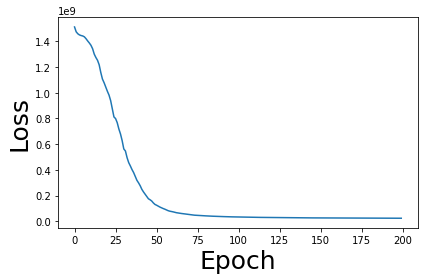

In [7]:
%%time
train_SGPR(
    model,
    optimizer=tf.keras.optimizers.Adam(lr),
    epochs=nepochs
)

print(
    f"Training error: {mean_squared_error(Y, model.predict_f(X)[0])}"
)

# Sample Bounded model

In [10]:
%%time
mcmc_points = 3000
num_burnin = mcmc_points * 0.3
initialise_chains = np.mean(X, axis=0)

tight_priors = {
    param: tfp.distributions.Uniform(
        unscaled_data[param].min(), unscaled_data[param].max()
    )
    for param in param_names
}

density_model = BoundedDensityModel(
    likelihood=model.predict_f,
    param_names=param_names,
    priors=tight_priors,
    parameters_scaler=x_scaler,
    y_scaler=y_scaler,
)

print("Running chain..")
all_samples = density_model.sample_density(
    num_results=mcmc_points,
    num_burnin_steps=int(num_burnin),
    initialise_chains=initialise_chains + 1e-3 * np.random.randn(30, X.shape[1]),
    sampler="HMC",
)

Running chain..
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Running sampler with SimpleStepSizeAdaptation


/home/virginia.demilio/.conda/envs/gp4gw/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 6min 10s, sys: 125 ms, total: 6min 10s
Wall time: 6min 24s


In [11]:
combine_chains = np.zeros((mcmc_points * 30, dim))
for i in range(dim):
    combine_chains[:, i] = all_samples[:, :, i].numpy().flatten()
gp_samples = x_scaler.inverse_transform(combine_chains)

az_data = convert_to_arviz_data(all_samples, x_scaler, param_names)

az.summary(az_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chirp_mass_source,1.187,0.002,1.185,1.191,0.000,0.000,5575.0,9481.0,1.00
symmetric_mass_ratio,0.248,0.002,0.244,0.250,0.000,0.000,12569.0,14526.0,1.00
lambda_tilde,469.326,232.466,91.383,853.073,3.691,2.610,3278.0,2931.0,1.01
delta_lambda,6.276,133.344,-252.308,262.121,1.081,1.028,16027.0,15593.0,1.00


In [12]:
latex_param_names = [
    r"$\mathcal{M}$",
    r"$\eta$",
    r"$\tilde{\Lambda}$",
    r"$\delta\tilde{\Lambda}$",
]

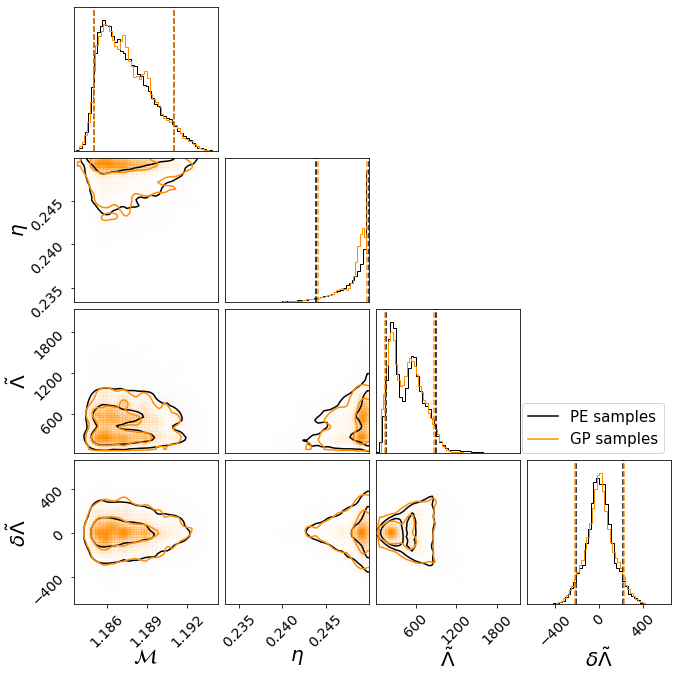

In [13]:
%matplotlib inline

blue_line = matplotlib.lines.Line2D([], [], color='k', label='PE samples')
red_line = matplotlib.lines.Line2D([], [], color='darkorange', label='GP samples')
fig1 = corner.corner(
    unscaled_data[param_names],
    bins=50,
    labels=latex_param_names,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="k",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig = corner.corner(
    gp_samples,
    fig=fig1,
    bins=50,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    labels=latex_param_names,
    color="darkorange",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig.get_axes()[4].tick_params(which="major", bottom=False)
fig.get_axes()[5].tick_params(which="both", bottom=False)
fig.get_axes()[8].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", left=False)
fig.get_axes()[10].tick_params(which="both", bottom=False)
fig.get_axes()[13].tick_params(which="both", left=False)
fig.get_axes()[14].tick_params(which="both", left=False)
fig.get_axes()[0].tick_params(which="both", bottom=False)

for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=14)

plt.legend(handles=[blue_line,red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4, fontsize=15)
# plt.savefig("./gp_EOS.png", dpi=100)